In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

directories = [
    "correct_noise_simple_broad",
    "correct_noise_simple_narrow",
    "correct_noise_scattered",
    "correct_noise_complex",
    "correct_noise_drifting",
]

data = []
labels = []

for class_idx, directory in enumerate(directories):
    data_dir = f"/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/{directory}"
    data_per_directory = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            dynamic_spectra_w_pulse = np.load(os.path.join(data_dir, filename))

            data_per_directory.append(dynamic_spectra_w_pulse)
            labels.append(class_idx)

    data_per_directory = np.array(data_per_directory)[:100]
    data.append(data_per_directory)

# Concatenate the data and labels
data = np.concatenate(data, axis=0)
labels = np.array(labels)

# Split the data into training and testing sets while maintaining class balance
test_size = 0.2
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_size, random_state=42)

print(data_test.shape)

(100, 1024, 512)


In [49]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Output values between 0 and 1 for MNIST
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(decoded.size(0), 1, 28, 28)  # Reshape to (batch_size, 1, 28, 28)
        return decoded

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the autoencoder
autoencoder = Autoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        outputs = autoencoder(inputs)
        loss = loss_fn(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the autoencoder
autoencoder.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        reconstructed = autoencoder(inputs)
        break  # Only test one batch for simplicity


Epoch [1/10], Loss: 0.0323
Epoch [2/10], Loss: 0.0239
Epoch [3/10], Loss: 0.0180
Epoch [4/10], Loss: 0.0154
Epoch [5/10], Loss: 0.0161
Epoch [6/10], Loss: 0.0188
Epoch [7/10], Loss: 0.0136
Epoch [8/10], Loss: 0.0160
Epoch [9/10], Loss: 0.0158
Epoch [10/10], Loss: 0.0112


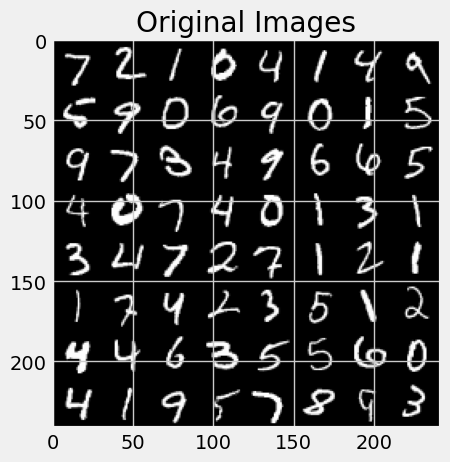

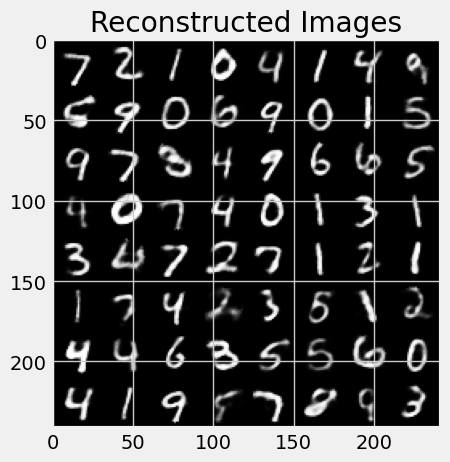

In [47]:
def imshow(img, title):
    img = img.permute(1, 2, 0)  # Change (1, 28, 28) to (28, 28, 1)
    plt.imshow(img.squeeze(), cmap='gray')  # Remove the singleton dimension
    plt.title(title)
    plt.show()

# Plot original images
imshow(torchvision.utils.make_grid(inputs), "Original Images")

# Plot reconstructed images
imshow(torchvision.utils.make_grid(reconstructed), "Reconstructed Images")

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Define the autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Convert data to PyTorch tensors
data_train_tensor = torch.Tensor(data_train[:, None, :])
data_test_tensor = torch.Tensor(data_test[:, None, :])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(data_train_tensor, torch.LongTensor(labels_train))
test_dataset = TensorDataset(data_test_tensor, torch.LongTensor(labels_test))

batch_size = 16  # Adjust as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the autoencoder
conv_autoencoder = ConvAutoencoder()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for data, _ in train_loader:
        inputs = data
        outputs = conv_autoencoder(inputs)
        loss = loss_fn(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the autoencoder
conv_autoencoder.eval()
with torch.no_grad():
    for data, _ in test_loader:
        inputs = data
        reconstructed = conv_autoencoder(inputs)
        break  # Only test one batch for simplicity


Epoch [1/10], Loss: 0.1682
Epoch [2/10], Loss: 0.0765
Epoch [3/10], Loss: 0.0167
Epoch [4/10], Loss: 0.0060
Epoch [5/10], Loss: 0.0039
Epoch [6/10], Loss: 0.0033
Epoch [7/10], Loss: 0.0031
Epoch [8/10], Loss: 0.0031
Epoch [9/10], Loss: 0.0029
Epoch [10/10], Loss: 0.0026


In [10]:
def plot_dynamic_spectra(dynamic_spectra, title="Dynamic Spectra"):
    """
    Plot a dynamic spectrum with horizontal time axis and reversed frequency axis.

    Parameters:
        dynamic_spectra (numpy.ndarray): The dynamic spectrum to plot.
        title (str): The title for the plot (default is "Dynamic Spectra").

    Returns:
        None
    """
    # Calculate the time step based on the number of time samples
    num_time_samples = dynamic_spectra.shape[0]
    time_step = 0.0000256  # Default time step in seconds

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

    plt.figure(figsize=(10, 6))
    plt.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis", extent=extent)
    plt.xlabel("Time (ms)", size=14)
    plt.ylabel("Frequency (MHz)", size=14)
    plt.colorbar()
    plt.title(title, size=16)
    plt.show()

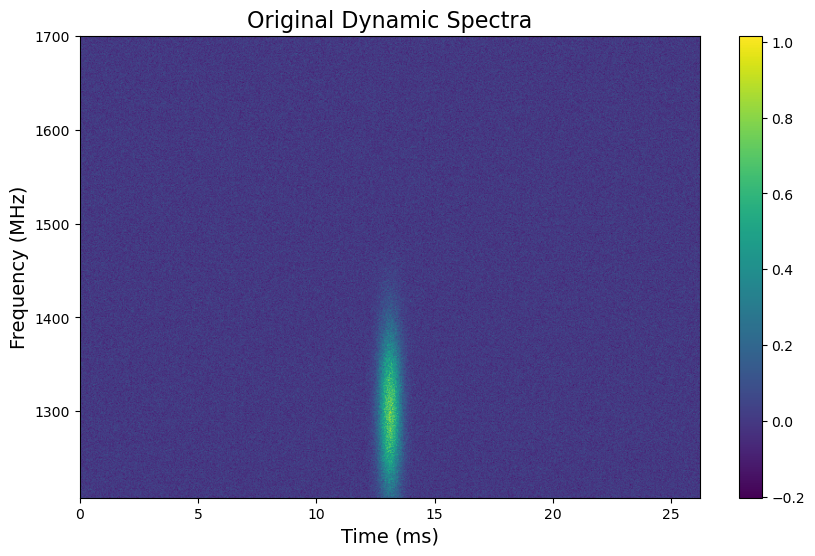

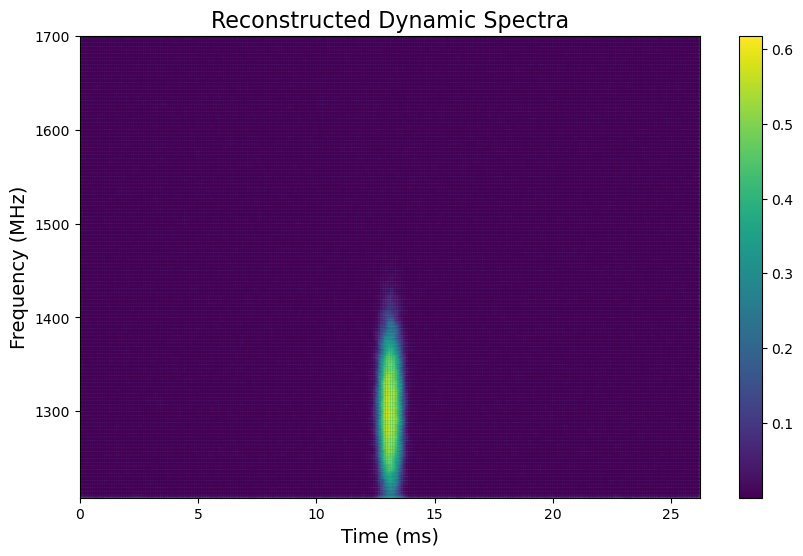

In [19]:
# Testing the autoencoder
conv_autoencoder.eval()
with torch.no_grad():
    for data, _ in test_loader:
        inputs = data
        reconstructed = conv_autoencoder(inputs)
        break  # Only test one batch for simplicity

# Convert tensors to numpy arrays for plotting
original_np = inputs[3].numpy().reshape((1024, 512))
reconstructed_np = reconstructed[3].numpy().reshape((1024, 512))

# Visualize original and reconstructed data
plot_dynamic_spectra(original_np, title="Original Dynamic Spectra")
plot_dynamic_spectra(reconstructed_np, title="Reconstructed Dynamic Spectra")
